In [1]:
import pandas as pd
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

In [2]:
ls

APOKASC_cat_v6.6.1.fits.gz            __pycache__/
CarreraLike.ipynb                     age2age.pdf
LMC_Ages.ipynb                        age2age_PCA_OLS.pdf
LMC_DR16_all_PDF.fits.gz              age2age_PCA_OLS2.pdf
MADdist.pdf                           age_functions.py
MagellanicStream.py                   agemap.jpg
PCAOLS_uncert.pdf                     b.txt
PCAOLS_uncert2.pdf                    depPCAthenOLS.ipynb
PCAandOLS.ipynb                       housing.csv
README.md                             lmc_rgbmembers.r13-l33-58672.fits.gz
StellAANN.ipynb                       logisochrones.dat
TestDimReduce.ipynb                   parsec3_3.dat
Weights1.txt                          w1.txt
Weights2.txt                          w2.txt


In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8.1 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
xy, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

<font size='20'>
    <b>
        Create Neural Network
    </b>
</font>

In [4]:
import numpy as np
from tqdm import tqdm_notebook

class Neural_Network(object):
    '''
    Create a 3 layered (input, hidden, output) feedforward neural network with back propagation and bias. 
    '''
    
    def __init__(self, input_width, hidden_width, learning_rate, number_of_epochs):
        '''
        Parameters:
        ----------
            input_width: (int) number of nodes in input layer
            hidden_width: (int) number of nodes in hidden layer
            learning_rate: (float) learning rate 
            number_of_epochs: (int) how many epochs to use when training
        '''
        
        # Widths of layers
        self.InputWidth = input_width
        self.HiddenWidth = hidden_width
        self.OutputWidth = 1
        
        # Weights
        self.Weights1 = np.random.randn(self.InputWidth,self.HiddenWidth)*0.2
        self.Weights2 = np.random.randn(self.HiddenWidth,self.OutputWidth)*0.2
        
        # Hidden Layer biases
        self.b1 = np.random.randn(self.HiddenWidth)
        self.b2 = np.random.randn(self.OutputWidth)
        
        # learning rate
        self.eta = learning_rate 
        
        # number of epochs
        self.epochs = number_of_epochs
        
   
    # Sigmoid activation function and derivative
    def Sigmoid(self,z):
        '''
        Parameters:
        ----------
            z: (float) number to plug into sigmoid function
        '''
        return 1./(1.+np.exp(-np.float128(z)))
    
    
    def DerivSigmoid(self,z):
        '''
        Parameters:
        ----------
            z: (float) number to plug into derivative of sigmoid function
            sigmoid already applied to z
        '''
        return self.Sigmoid(z)*(1.-self.Sigmoid(z))
#         return z*(1.-z)
    
    
    # Propagation functions
    def FeedForward(self,X):
        '''
        Parameters: 
        ----------
            X: dataset of inputs
        '''
        # feed through whole neural network
        self.First = np.dot(X, self.Weights1) + self.b1
        self.Second = self.Sigmoid(self.First)
        Third = np.dot(self.Second,self.Weights2) #+ self.b2
        
        return Third
        
    
    def BackPropagation(self,X,yPredicted,yObserved): 
        '''
        Parameters:
        ----------
            X: dataset of inputs
            yPredicted: known output for X
            yObserved: calculated outputs going from input layer to output layer once
        '''
        # Output layer error and output delta
        self.OutputError = yPredicted - yObserved
        self.OutputDelta = self.OutputError*self.DerivSigmoid(yObserved)
        
        # Hidden layer error and hidden delta
        self.HiddenError = np.dot(self.OutputDelta,self.Weights2.T)
        self.HiddenDelta = self.HiddenError*self.DerivSigmoid(self.First)
        #self.HiddenDelta = self.HiddenError*self.DerivSigmoid(self.Second)
        
        # Update weights 
        self.Weights1 += self.eta*np.dot(X.T,self.HiddenDelta)
        self.Weights2 += self.eta*np.dot(self.Second.T,self.OutputDelta)
        
#         print(self.b)
#         print(np.ones(self.HiddenWidth))
#         print(self.HiddenDelta)

#         print('bias')
#         print(self.b)
#         print('bias adjust')
#         print(self.HiddenWidth)
#         print(self.HiddenDelta)
#         print(np.shape(self.HiddenDelta))
#         print(self.eta*np.dot(np.ones(self.HiddenWidth).T,self.HiddenDelta))
#         print(np.add(self.b,self.eta*np.dot(np.ones(self.HiddenWidth),self.HiddenDelta)))
        
        # Updates biases
        self.b1 += self.eta*np.dot(np.ones(len(self.First)),self.HiddenDelta)
#         self.b2 += self.eta*np.dot(np.ones(len(self.FeedForward(X))),self.OutputDelta)
#         self.b = self.b + self.eta*np.dot(np.ones(self.HiddenWidth),self.HiddenDelta)
#         self.b = np.add(self.b,self.eta*np.dot(np.ones(self.HiddenWidth),self.HiddenDelta))
    
   
    # Train on dataset
    def Train(self,X,yPredicted):
        '''
        Train neural network on data in epochs and print final loss
        
        Parameters:
        ----------
            X: dataset of inputs to train
            yPredicted: known output for X
        '''
        
        # feedforward and backpropagate for the specified number of epochs
        for i in tqdm_notebook(range(self.epochs)):
            self.BackPropagation(X,yPredicted,self.FeedForward(X))
        
        # print out loss
        print('Training Loss (MSE): ', np.mean(np.square(yPredicted - self.FeedForward(X))))
        
    
    # Predict output from new input
    def Predict(self,XNew):
        '''
        Predict the output given a new dataset XNew
        '''
        return self.FeedForward(XNew)
    
    
    # Utility functions
    def SaveWeights(self):
        '''
        Save weights from the input layer to the hidden layer as 'Weights1.txt'
        and save weights from hidden layer to output as 'Weights2.txt'.
        '''
        np.savetxt('Weights1.txt',self.Weights1,fmt='%s')
        np.savetxt('Weights2.txt',self.Weights2,fmt='%s')
        np.savetxt('b.txt',self.b1,fmt='%s')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

xAll = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T #np.array(([2, 9], [1, 5], [3, 6], [5, 10]), dtype=float) # input data
# scaler = MinMaxScaler()
# scaler.fit(xAll)
# scxAll = scaler.transform(xAll)

y = parsec['logAge']/np.max(parsec['logAge']) #np.array(([92], [86], [89]), dtype=float) # output

# scale units
# xAll = xAll/np.amax(xAll, axis=0) # scaling input data
# y = y/100 # scaling output data (max test score is 100)

# # split data
# X = np.split(xAll, [3])[0] # training data
# XNew = np.split(xAll, [3])[1] # testing data

X_train, X_test, y_train, y_test = train_test_split(xAll, y, test_size=0.60)

In [8]:
# np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg'],
#           np.multiply(parsec['logTe'],parsec['Ksmag']),np.multiply(parsec['logTe'],np.log10(parsec['Zini']/0.02)),
#           np.multiply(parsec['logTe'],parsec['logg']),np.multiply(parsec['Ksmag'],np.log10(parsec['Zini']/0.02)),
#           np.multiply(parsec['Ksmag'],parsec['logg']),np.multiply(np.log10(parsec['Zini']/0.02),parsec['logg']),
#           np.square(parsec['logTe']),np.square(parsec['Ksmag']),np.square(np.log10(parsec['Zini']/0.02)),
#           np.square(parsec['logg'])])
max(parsec['logAge'])







10.05

In [12]:
NN = Neural_Network(input_width=4,hidden_width=3,learning_rate=0.5,number_of_epochs=100000)
NN.Train(pd.DataFrame(X_train),pd.DataFrame(y_train))
NN.SaveWeights()
# NN.Predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training Loss (MSE):  logAge    729681.108257
dtype: float128


(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        5.000e+00, 8.000e+00, 1.600e+01, 8.934e+03]),
 array([855.14991929, 855.1499193 , 855.1499193 , 855.1499193 ,
        855.1499193 , 855.1499193 , 855.1499193 , 855.1499193 ,
        855.1499193 , 855.1499193 , 855.1499193 ], dtype=float128),
 <a list of 10 Patch objects>)

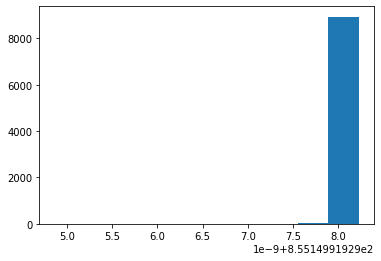

In [13]:
import matplotlib.pyplot as plt
plt.hist(NN.Predict(X_test))

In [187]:
pd.DataFrame(X_train)
pd.DataFrame(y_train)

,logAge
0,9.50
1,9.35
2,8.60
3,9.50
4,9.50
5,9.50
6,8.45
7,8.45
8,9.20
9,9.50
